# 1. Importing libraries

In [1]:
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch as T 
import torch.nn.functional as F
from util import plot_learning_curve

# 2. DQN Class

Defining the network for the agent

In [2]:
class LinearDeepNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr)
        self.loss  = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.relu(self.fc1(state))
        actions = self.fc2(layer1)

        return actions

# 3. Agent class

Initializing the agent network and agents action functions

In [3]:
class Agent():
    def __init__(self, n_actions, lr, input_dims, gamma = 0.99, epsilon = 1.0, eps_dec = 1e-5, eps_min = 0.01):

        self.lr = lr
        self.input_dims = input_dims
        self.gamma = gamma
        self.epsilon = epsilon 
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.n_actions = n_actions
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype = T.float).to(self.Q.device)
            actions= self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        
        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - ( self.eps_dec *self.epsilon if self.epsilon > self.eps_min else self.eps_min)

    def learn(self, state, action,reward,state_):
        self.Q.optimizer.zero_grad()
        
        states = T.tensor(state, dtype = T.float).to(self.Q.device)
        actions = T.tensor(action).to(self.Q.device)
        rewards = T.tensor(reward).to(self.Q.device)
        states_ =  T.tensor(state_, dtype = T.float).to(self.Q.device)

        q_pred = self.Q.forward(states)[actions]

        q_next = self.Q.forward(states_).max()

        q_target = reward + self.gamma * q_next
        
        loss = self.Q.loss(q_target, q_pred). to(self.Q.device)

        loss.backward()

        self.Q.optimizer.step()
        self.decrement_epsilon()


# 4. Main loop

episode  0 score 31.0 avg score 31.0 epsilon 0.999690
episode  100 score 16.0 avg score 23.5 epsilon 0.976481
episode  200 score 21.0 avg score 23.0 epsilon 0.954249
episode  300 score 19.0 avg score 20.1 epsilon 0.935223
episode  400 score 19.0 avg score 23.4 epsilon 0.913611


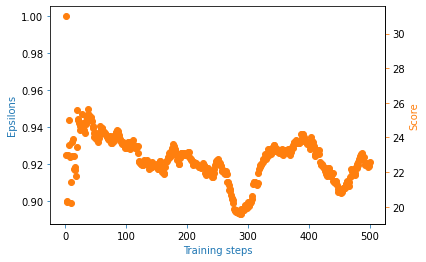

In [5]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    n_games = 500
    scores = []
    eps_history = []
    
    # Initializing the agent class and its actions
    agent =Agent(input_dims = env.observation_space.shape, n_actions= env.action_space.n, lr = 0.0001)

    for i in range(n_games):
        score = 0
        done = False
        obs = env.reset()

        while not done:
            action = agent.choose_action(obs)
            obs_, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, obs_)
            obs = obs_
            score += reward

        scores.append(score)
        eps_history.append(agent.epsilon)

        if i % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print('episode ', i, 'score %.1f avg score %.1f epsilon %2f' %(score, avg_score, agent.epsilon))


    filename = 'cartpole_naive_dqn.png'
    x = [ i+1 for i in range(n_games)]

    plot_learning_curve(x, scores, eps_history, filename)


# Plotting the data

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
def plot_learning_curve(x, scores, epsilons, filename):
    fig =plt.figure()
    ax= fig.add_subplot(111, label ='1')
    ax2= fig.add_subplot(111, label ='2')

    ax.plot(x, epsilons, color = 'C0')
    ax.set_xlabel('Training steps', color = "C0")
    ax.set_ylabel("Epsilons", color = "C0")
    ax.tick_params(axis = 'x', color = "C0")
    ax.tick_params(axis = 'y', color = "C0")

    N=len(scores)

    running_avg = np.empty(N)

    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100): (t+1)])

    ax2.scatter(x, running_avg , color = "C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color = "C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', color = "C1")

    plt.savefig(filename)